In [1]:
#%matplotlib qt

import RutishauserLabtoNWB.events.newolddelay.python.analysis.single_neuron as single_neuron
import RutishauserLabtoNWB.events.newolddelay.python.analysis.helper as helper
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import RutishauserLabtoNWB as RLab
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import seaborn
import scipy
import pynwb
import hdmf

import os
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
import seaborn as sns
from tqdm.auto import trange
from mpl_toolkits import mplot3d
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA

import torch
from torch.distributions import Categorical, MultivariateNormal, Normal, \
    LowRankMultivariateNormal, kl_divergence

from scipy.signal import find_peaks
from sklearn.model_selection import cross_val_score
from scipy.ndimage import gaussian_filter
from sklearn.manifold import Isomap

import GPy
from tqdm.auto import tqdm


In [2]:
# Getting data from files
device = torch.device('cpu')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

# Load the data for a single person
nwb_data_path = 'Desktop/ml_final_project/NWBData/P29CS_NOID70.nwb' #P9HMH_NOID5.nwb'
nwb_file = helper.read(nwb_data_path)
neurons = single_neuron.extract_neuron_data_from_nwb(nwb_file)

Session_id:  CS29_70
Channel:  9
Cell_id:  0
Number of spikes: 1359
Session_id:  CS29_70
Channel:  10
Cell_id:  1
Number of spikes: 591
Session_id:  CS29_70
Channel:  25
Cell_id:  2
Number of spikes: 74
Session_id:  CS29_70
Channel:  25
Cell_id:  2
Number of spikes: 238
Session_id:  CS29_70
Channel:  25
Cell_id:  2
Number of spikes: 176
Session_id:  CS29_70
Channel:  25
Cell_id:  2
Number of spikes: 89
Session_id:  CS29_70
Channel:  26
Cell_id:  3
Number of spikes: 251
Session_id:  CS29_70
Channel:  26
Cell_id:  3
Number of spikes: 1362
Session_id:  CS29_70
Channel:  28
Cell_id:  4
Number of spikes: 554
Session_id:  CS29_70
Channel:  29
Cell_id:  5
Number of spikes: 341
Session_id:  CS29_70
Channel:  29
Cell_id:  5
Number of spikes: 175
Session_id:  CS29_70
Channel:  29
Cell_id:  5
Number of spikes: 1791
Session_id:  CS29_70
Channel:  33
Cell_id:  6
Number of spikes: 2310
Session_id:  CS29_70
Channel:  33
Cell_id:  6
Number of spikes: 171
Session_id:  CS29_70
Channel:  33
Cell_id:  6
N

In [3]:
# Data Pre-Processing - Spike binning

num_neurons = len(neurons)
bin_size = 50 # ms
xlim=(0, 4000) # ms
num_bins = int(np.floor((xlim[1] - xlim[0]) / bin_size))

num_trials = 100

neuron_ids = set()


events_learn, timestamps_learn, events_recog, timestamps_recog = helper.get_event_data(nwb_file)

timestamps = [timestamps_learn, timestamps_recog]
event_times = []

trial_data = np.ndarray(shape=(num_trials, num_neurons, num_bins))

for j, neuron in enumerate(neurons):
    trials = neuron.trials_recog
    cats=[]
    for k, trial in enumerate(trials):
        cats.append(trial.category_id)
        spike_rates = []
        times = []
        mean_fr = trial.win_spike_rate(neuron.spike_timestamps, xlim[0], xlim[1]) # in Hz
        for i in range(num_bins):
            start = xlim[0] + i * bin_size
            end = start + bin_size
            spike_rate = trial.win_spike_rate(neuron.spike_timestamps, start, end)
            times.append(start)
            spike_rates.append(spike_rate)
                
        neuron_ids.add(neuron.neuron_id)
        trial_data[k,j,:] = spike_rates


TIME_SCALING = 10**6
event_idx = 0

trial_event_idx = []
event_markers = []

for trial in trials:
    event_times = []
    markers = []
    for i in range(num_bins):
        start = trial.stim_on/TIME_SCALING + (xlim[0]/1000) + (i*bin_size/1000)# + (xlim[0] + (i * bin_size))*1000
        end = (start + bin_size/1000)
        timestamp = timestamps_recog[event_idx]
        while timestamp < start and event_idx < len(timestamps_recog)-1:
            event_idx += 1
            timestamp = timestamps_recog[event_idx]
        while timestamp >= start and timestamp < end and event_idx < len(timestamps_recog)-1:
            markers.append(int(events_recog[event_idx]))
            event_times.append(i)
            event_idx += 1
            timestamp = timestamps_recog[event_idx]
    trial_event_idx.append(event_times)
    event_markers.append(markers)

In [4]:
# Plotting Data per trial
def plot_data(data):
    color = ['deeppink','red','orange','cyan','chartreuse']
    plt.figure(figsize=(20, 50))
    for trial in range(10):
        for neuron in range(num_neurons):
            col = color[neurons[neuron].trials_recog[trial].category_id-1]
            plt.plot(np.arange(num_bins), 5*data[trial,neuron,:]+(neuron)+(trial*24), color=col)
    plt.show()

In [5]:
# Putting data in elephant GPFA spike train format
timestep = bin_size*pq.ms
spiketrains = []
for trial in range(num_trials):
    spikes_per_neuron = []
    for neuron in range(num_neurons):
        rates = inhomogeneous_poisson_process(neo.AnalogSignal(trial_data[trial,neuron,:], sampling_rate=1/timestep, units=pq.Hz))
        spikes_per_neuron.append(rates)
    spiketrains.append(spikes_per_neuron)



 /Users/Thomas/anaconda3/lib/python3.7/site-packages/elephant/spike_train_generation.py:448: RuntimeWarning:divide by zero encountered in true_divide


In [6]:
# Using GPFA to find best latent space dimensionality and plotting
# (only run once, takes a long time)
# latent_dims = np.arange(1,num_neurons)
# gpfa_log_likes = []
# for dim in latent_dims:
#     gpfa = GPFA(bin_size=bin_size*pq.ms, x_dim = dim)
#     log_likelihood = cross_val_score(gpfa, spiketrains, cv=2, n_jobs=1, verbose=True)
#     gpfa_log_likes.append(log_likelihood)


# Plotting log likelihood of GPFA dimensionality exploration
# gpfa_mean = np.mean(gpfa_log_likes, axis=-1)
# plt.plot(latent_dims, gpfa_mean, '.-')
# plt.vlines(latent_dims[int(0.8*np.argmax(gpfa_means))], 0, np.max(gpfa_means))

In [7]:
# Running GPFA to get trajectories with chosen latent dimensionality
latent_dim = 5
gpfa = GPFA(bin_size=bin_size*pq.ms, x_dim = latent_dim)
trajectories_gpfa = gpfa.fit_transform(spiketrains)

Initializing parameters using factor analysis...

Fitting GPFA model...


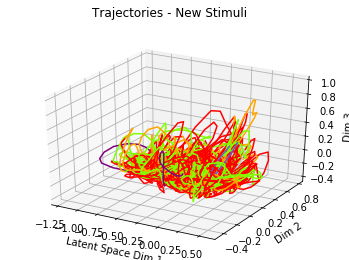

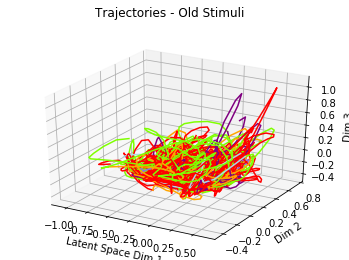

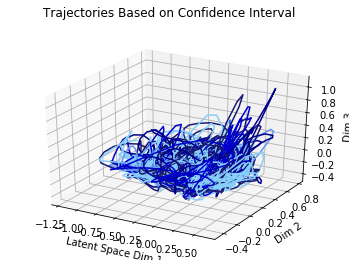

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
# Function to 3D plot trajectories
def plot_trajectories_3d(trajectories):
    titles = ['Trajectories - New Stimuli', 'Trajectories - Old Stimuli']
    fig1 = plt.figure(1)
    plt.suptitle(titles[0])
    fig2 = plt.figure(2)
    plt.suptitle(titles[1])
    fig3 = plt.figure(3)
    plt.suptitle("Trajectories Based on Confidence Interval")
    fig4 = plt.figure(4)
    fig5 = plt.figure(5)
    
    ax1 = fig1.add_subplot(1,1, 1, projection='3d')
    ax1.set_xlabel('Latent Space Dim 1')
    ax1.set_ylabel('Dim 2')
    ax1.set_zlabel('Dim 3')

    ax2 = fig2.add_subplot(1, 1, 1, projection='3d')
    ax2.set_xlabel('Latent Space Dim 1')
    ax2.set_ylabel('Dim 2')
    ax2.set_zlabel('Dim 3')
    
    ax3 = fig3.add_subplot(1, 1, 1, projection='3d')
    ax3.set_xlabel('Latent Space Dim 1')
    ax3.set_ylabel('Dim 2')
    ax3.set_zlabel('Dim 3')
    
    axs = [ax1, ax2]

    old_traj_idx = []
    new_traj_idx = []

    traj_label_idx = [old_traj_idx, new_traj_idx]
    
    color_dic = {
        0: 'white',
        1: 'red',
        2: 'orange',
        3: 'chartreuse',
        31: 'lightblue',
        32: 'deepskyblue',
        33: 'navy',
        34: 'slateblue',
        35: 'mediumpurple',
        36: 'purple',
        6: 'yellow',
        66: 'black'
    }
    
    color_dic2 = {
        1: 'lightskyblue',
        2: 'cornflowerblue',
        3: 'royalblue',
        4: 'mediumblue',
        5: 'darkblue',
        6: 'midnightblue'
    }
    for i, traj in enumerate(trajectories):
        idx = neurons[0].trials_recog[i].label
        ax = axs[idx]
        events = trial_event_idx[i]
        markers = event_markers[i] 
        for k in range(len(events)-1):
            col = color_dic[markers[k]]
            ax.plot3D(traj[0,events[k]:events[k+1]+1], traj[1,events[k]:events[k+1]+1], traj[2,events[k]:events[k+1]+1], color=col)
        if len(events) > 1 and markers[-1] != 1:
            col = color_dic[markers[-1]]
            ax.plot3D(traj[0,events[k+1]:], traj[1,events[k+1]:], traj[2,events[k+1]:], color=col)
        
        ax3.plot3D(traj[0,:], traj[1,:], traj[2,:], color=color_dic2[neurons[0].trials_recog[i].response])
        
        # Plotting first two principal componenents with event markers
#         plt.figure(idx+4)
#         colors = [color_dic[j] for j in markers]
#         plt.plot(range(traj.shape[1]), traj[0,:], color='dimgray')
#         plt.plot(range(traj.shape[1]), traj[1,:]+2, 'lightgray')
#         plt.scatter(events, traj[0,events], c=colors, zorder=10)
#         plt.scatter(events, traj[1,events]+2, c=colors, zorder=10)

        traj_label_idx[idx].append(i)
        
    return traj_label_idx

traj_label_idx_gpfa = plot_trajectories_3d(trajectories_gpfa)

Mean of Covariance of Trajectories Across Trials:
New Stimuli      : 0.0005844844611242288
Old Stimuli      : 0.0003725220953420362
New x Old Stimuli: 0.0006297486889297135
All Stimuli      : 0.00019913427258094619


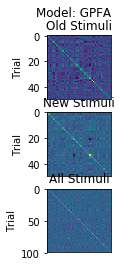

In [17]:
# Visualizing covariance matrices for given trajectories
def covariance_matrices(trajectories, traj_label_idx, method):
    print("Mean of Covariance of Trajectories Across Trials:")
    
    new_trajs = np.ndarray(shape=(len(traj_label_idx[1]), trajectories[0].shape[0], num_bins))
    for i, idx in enumerate(traj_label_idx[0]):
        new_trajs[i,:,:] = trajectories[idx]
    plt.subplot(3,1,2)
    plt.xticks([])
    covar_mean, _ = calculate_cov(new_trajs)
    print("New Stimuli      :", np.mean(covar_mean))
    plt.imshow(covar_mean)
    plt.title(f'New Stimuli')
    plt.ylabel('Trial')
    #plt.xlabel(f"Mean Covariance: {np.mean(covar_mean)}")
    
    old_trajs = np.ndarray(shape=(len(traj_label_idx[0]), trajectories[0].shape[0], num_bins))
    for i, idx in enumerate(traj_label_idx[1]):
        old_trajs[i,:,:] = trajectories[idx]
    plt.subplot(3,1,1)
    plt.xticks([])
    plt.suptitle(f'Model: {method}')
    covar_mean, _ = calculate_cov(old_trajs)
    print("Old Stimuli      :", np.mean(covar_mean))
    plt.imshow(covar_mean)
    plt.title(f'Old Stimuli')
    plt.ylabel('Trial')
    #plt.xlabel(f"Mean Covariance: {np.mean(covar_mean)}")



    plt.subplot(3,1,3)
    plt.xticks([])
    plt.ylabel('Trial')

    # Using random samples of old and new trials to find covariance among these
    covar_means = []
    mc_iters = 1000
    for i in range(mc_iters):
        covars = []
        ran_new = np.random.randint(0, new_trajs.shape[0], int(new_trajs.shape[0]/2))
        ran_old = np.random.randint(0, old_trajs.shape[0], int(old_trajs.shape[0]/2))
        news = new_trajs[ran_new,:,:]
        olds = old_trajs[ran_old,:,:]
        for j in range(news.shape[1]):
            covar = np.cov(news[:,j,:], olds[:,j,:])
            covars.append(covar)
        covar_mean = np.mean(np.asarray(covars), axis=0)
        covar_means.append(covar_mean)
    print("New x Old Stimuli:", np.mean(covar_means))
    plt.title(f'New X Old Stimuli')
    #plt.xlabel(f"Mean Covariance: {np.mean(covar_mean)}")


    covar_mean, _ = calculate_cov(np.stack(trajectories))
    print("All Stimuli      :", np.mean(covar_mean))
    plt.title('All Stimuli')
    plt.imshow(covar_mean)
    
# Caculating covariance matrix for given trajectories
def calculate_cov(trajectories):
    covars = []
    for i in range(trajectories.shape[1]):
        covar = np.cov(trajectories[:,i,:])
        covars.append(covar)
    covar_mean = np.mean(np.asarray(covars), axis=0)
    return covar_mean, np.asarray(covars)
    
covariance_matrices(trajectories_gpfa, traj_label_idx_gpfa, 'GPFA')

In [18]:
# Kernel Smoothing Data
smooth_data = np.ndarray(shape=trial_data.shape)
for trial in range(num_trials):
    for neuron in range(num_neurons):
        smooth_data[trial,neuron,:] = gaussian_filter(trial_data[trial,neuron,:], sigma=2.25)

#plot_data(smooth_data)

Text(0.5, 0, 'Latent Space Dimensionality')

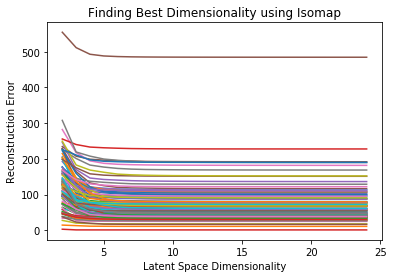

In [19]:
# Performing Isomap Latent Space Dimensionality Search

latent_dims = np.arange(2,25)

iso_log_likes = np.ndarray(shape=(len(latent_dims), num_trials))

for i, dim in enumerate(latent_dims):
    for trial in range(num_trials):
        embedding = Isomap(n_components=dim)
        embedding.fit_transform(smooth_data[trial,:,:].T)
        iso_log_likes[i,trial] = embedding.reconstruction_error()  
plt.figure() 
plt.plot(latent_dims, iso_log_likes)
plt.title('Finding Best Dimensionality using Isomap')
plt.ylabel('Reconstruction Error')
plt.xlabel('Latent Space Dimensionality')

Text(0, 0.5, 'Covariance')

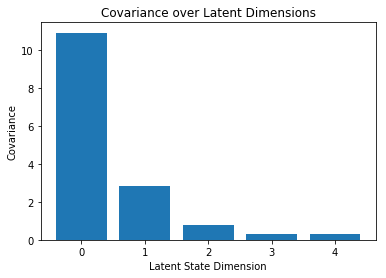

In [20]:
# Implementing Isomap with k=5
latent_dim = 5

iso_trajs = np.ndarray(shape=(num_trials,latent_dim,num_bins))
embedding = Isomap(n_components=latent_dim)

for trial in range(num_trials):
    iso_trajs[trial,:,:] = embedding.fit_transform(smooth_data[trial,:,:].T).T

cov = np.ndarray(latent_dim)  
covar_mean, covars = calculate_cov(iso_trajs)
cov = np.mean(covars, axis=(1,2))
plt.figure()
plt.bar(range(latent_dim), cov)
plt.title('Covariance over Latent Dimensions')
plt.xlabel("Latent State Dimension")
plt.ylabel('Covariance')

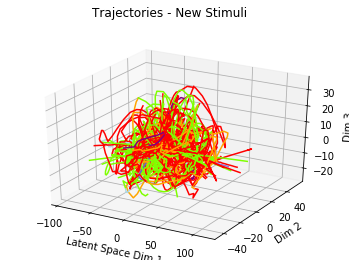

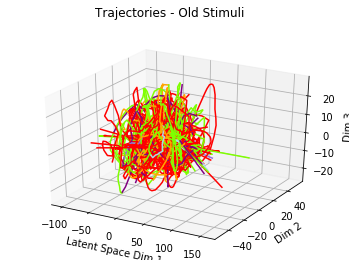

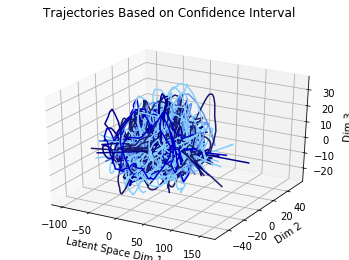

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [21]:
# Plotting Isomap trajectories
traj_label_idx_iso = plot_trajectories_3d(iso_trajs)

Mean of Covariance of Trajectories Across Trials:
New Stimuli      : 9.948932361891478
Old Stimuli      : 9.493148596368078
New x Old Stimuli: 8.963372683192743
All Stimuli      : 3.0288759359982085


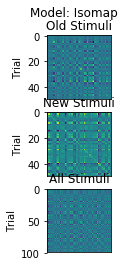

In [22]:
# Isomap covariance matrices
covariance_matrices(iso_trajs, traj_label_idx_iso, 'Isomap')

In [23]:
# Performing GPLVM using same latent dimensionality
gplvm_trajectories = np.ndarray(shape=(num_trials, latent_dim, num_bins))
for trial in tqdm(range(num_trials)):
    gplvm = GPy.models.BayesianGPLVM(smooth_data[trial,:,:].T, latent_dim)
    gplvm.optimize()
    trajectory = np.asarray(gplvm['latent_space.mean'].T)
    trajectory[np.isnan(trajectory)] = 0
    gplvm_trajectories[trial,:,:] = trajectory

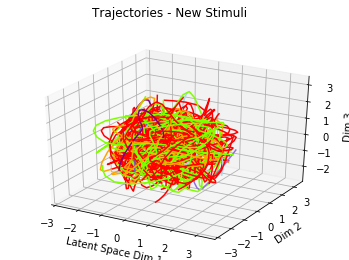

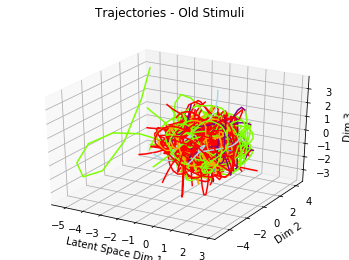

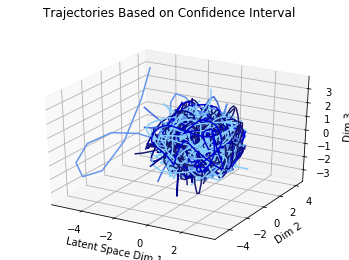

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
# Plotting GPLVM trajectories
traj_label_idx_gplvm = plot_trajectories_3d(gplvm_trajectories)

Mean of Covariance of Trajectories Across Trials:
New Stimuli      : 0.012964910121313886
Old Stimuli      : 0.016572582387522412
New x Old Stimuli: 0.02674600634596331
All Stimuli      : 0.007294916887106352


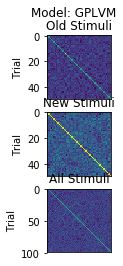

In [25]:
# Visualizing GPLVM Covariance
covariance_matrices(gplvm_trajectories, traj_label_idx_gplvm, 'GPLVM')